#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas_datareader.data as web

In [2]:
# Aquiring historical data of Amazon from Yahoo

amzn = web.DataReader("AMZN", "yahoo")

#### Before doing any of machine learning, let's explore the data

In [3]:
# Statistical information about the historical data

amzn.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1832.000000,1832.000000,1832.000000,1832.000000,1.832000e+03,1832.000000
mean,357.045824,360.703946,353.108815,357.129547,4.560130e+06,357.129547
std,209.189898,210.421236,207.690083,209.162172,3.054296e+06,209.162172
min,105.930000,111.290001,105.800003,108.610001,9.844000e+05,108.610001
25%,194.759995,197.282493,191.965004,195.062503,2.724025e+06,195.062503
50%,295.159988,298.880005,290.735000,295.240005,3.815850e+06,295.240005
75%,434.919998,438.762504,431.394996,434.522515,5.331400e+06,434.522515
max,913.799988,923.719971,905.619995,909.280029,4.242110e+07,909.280029


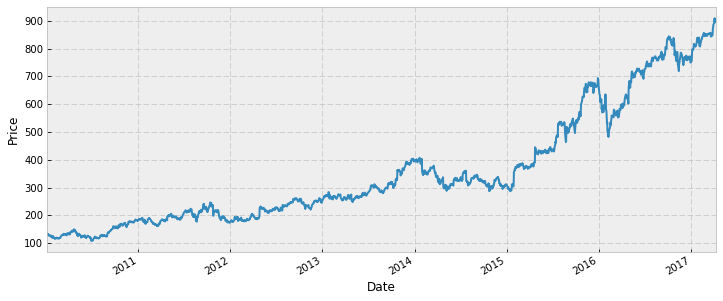

In [4]:
# Plotting Close price

amzn.Close.plot(figsize=(12, 5))
plt.ylabel('Price')
plt.show()

In [5]:
# Let's see how many times the price went up and how many time it went down compare to the previous day

amzn['UP/DOWN'] = amzn.Close.diff()[1:]

# Dropping NaN

amzn.dropna(inplace=True)

# Setting 1 if UP/DOWN is > 0, else -1

amzn['UP/DOWN'] = amzn['UP/DOWN'].apply(lambda x: 1 if x > 0 else -1)

In [6]:
# Counting how many 1 and -1

amzn["UP/DOWN"].value_counts()

 1    956
-1    875
Name: UP/DOWN, dtype: int64

In [7]:
amzn["UP/DOWN"].value_counts()/amzn["UP/DOWN"].value_counts().sum()

 1    0.522119
-1    0.477881
Name: UP/DOWN, dtype: float64

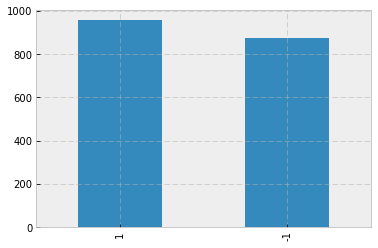

In [8]:
# plotting the result

amzn["UP/DOWN"].value_counts().plot(kind='bar')
plt.show()

In [9]:
# To have a better picture, let's convert numbers into percents

amzn["UP/DOWN"].value_counts()/amzn["UP/DOWN"].value_counts().sum()*100

 1    52.211906
-1    47.788094
Name: UP/DOWN, dtype: float64

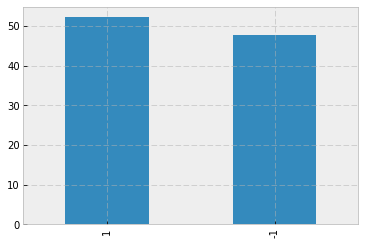

In [10]:
# Plotting the data

pct_up_down = amzn["UP/DOWN"].value_counts()/amzn["UP/DOWN"].value_counts().sum()*100
pct_up_down.plot(kind='bar')
plt.show()

# As you see, it is almost 50/50

It would be interesting to see if there is a correlation between UP or DOWN and a weekday

In [11]:
# Creating a new column with corresponding weekdays,
# where 0: "Monday", 1: "Tuesday", 2: "Wednesday", 3:"Thursday", 4:"Friday"

amzn["weekdays"] = amzn.index.weekday
amzn["weekdays"] = amzn["weekdays"].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3:"Thursday", 4:"Friday"})

In [12]:
amzn.tail()

,Open,High,Low,Close,Volume,Adj Close,UP/DOWN,weekdays
Date,,,,,,,,
2017-04-06,913.799988,917.190002,894.489990,898.280029,6331800,898.280029,-1,Thursday
2017-04-07,899.650024,900.090027,889.309998,894.880005,3695900,894.880005,-1,Friday
2017-04-10,899.630005,908.510010,899.000000,907.039978,3146600,907.039978,1,Monday
2017-04-11,907.039978,911.239990,897.500000,902.359985,3005500,902.359985,-1,Tuesday
2017-04-12,903.090027,904.090027,895.250000,896.229980,2439200,896.229980,-1,Wednesday


In [13]:
# Now let's see how many UPs and DOWNs per each day of week

amzn.groupby(by='weekdays')['UP/DOWN'].value_counts()

weekdays   UP/DOWN
Friday      1         191
           -1         176
Monday     -1         178
            1         163
Thursday    1         203
           -1         166
Tuesday     1         204
           -1         173
Wednesday   1         195
           -1         182
Name: UP/DOWN, dtype: int64

In [14]:
days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3:"Thursday", 4:"Friday"}

for day in range(5):
    ups = amzn[(amzn['weekdays']== days[day]) & (amzn['UP/DOWN']== 1)]['UP/DOWN'].count()
    downs = amzn[(amzn['weekdays']== days[day]) & (amzn['UP/DOWN']== -1)]['UP/DOWN'].count()
    up_ratio = ups / (ups + downs)
    down_ratio = downs/(ups + downs)
    print('{}  \t UP: {},  DOWN: {}'.format(days[day], round(up_ratio, 2), round(down_ratio, 2)))

Monday  	 UP: 0.48,  DOWN: 0.52
Tuesday  	 UP: 0.54,  DOWN: 0.46
Wednesday  	 UP: 0.52,  DOWN: 0.48
Thursday  	 UP: 0.55,  DOWN: 0.45
Friday  	 UP: 0.52,  DOWN: 0.48


The results show that chances of the price to go up are higher on Tuesday and Thursday, 54% and 55% which is a liitle
better than a random guess(50%).

###  Prediction of the Close price with Linear Regression (LR)

In this part we will try to predict the Close price based on the Open Price with machine learning. After finding out
the Open price in the morning, we can use it as input for our Linear Regression algorithm to predict the Close price. 
This prediction will help us to decide whether we should buy or sell our shares.

In [15]:
# Getting Open and Close prices only

o_c_df = amzn[["Open", "Close"]]

In [16]:
# Splitting the data into training(70%) and testing(30%) sets. We will preserve the sequence of the data

x, y = o_c_df["Open"].values, o_c_df["Close"].values

split = 0.7
n_train = int(o_c_df.shape[0] * split)
n_test = o_c_df.shape[0] - n_train

x_train, x_test = x[:n_train], x[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1281,), (550,), (1281,), (550,))

In [18]:
# Importing libraries

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

In [19]:
# Running machine learning. We need to reshape the data

lr = LinearRegression()
lr.fit(x_train.reshape(n_train, 1), y_train.reshape(n_train, 1))
lr_pred = lr.predict(x_test.reshape(n_test, 1))

Since this is a Linear Regression where we are tryng to predict a continuois value, we will use R2_score and RMSE( root-mean-square error) as the metrics of choice.

In [20]:
print("R2 score is:",r2_score(y_test, lr_pred).round(3))
print("RMSE is:", np.sqrt(mean_squared_error(y_test, lr_pred)).round(3))

R2 score is: 0.997
RMSE is: 8.203


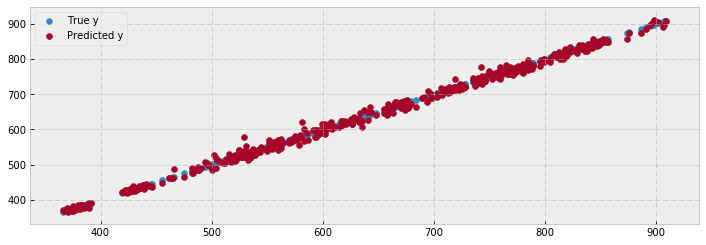

In [21]:
# Let's plot the results

plt.figure(figsize=(12, 4))
plt.scatter(y_test, y_test, label="True y")
plt.scatter(y_test, lr_pred, label="Predicted y")
plt.legend()
plt.show()

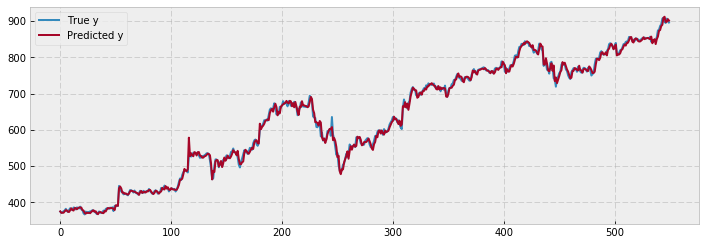

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="True y")
plt.plot(lr_pred, label="Predicted y")
plt.legend()
plt.show()

At first glance the algorithm performed well - a very high R2 score and both plots look very promising.
But we should explore the plot with actual and predicted prices with a closer look. To do that, we will make a plot with 
Bokeh charting library since it has a "zoom in" functionality.

In [23]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

In [24]:
f = figure(width=900, height=300)
f.line(np.arange(y_test.size),y_test, line_width=2, legend="True price")
f.line(np.arange(y_test.size),lr_pred.flatten(), color='red', line_width=2, legend="Predicted price")
f.legend.location = 'top_left'
show(f)

If you zoom in with "zoom box" tool at any regoin you will see that despite the predicted price is very close to
a real price, they have different directions. For example, tomorrow's price goes up relative today's price,
but the predicted tomorrow's price goes down. There is a difference in a trend. So, to get a clear picture about
the performace of LR, we will use the predicted prices as inputs for a UP/DOWN converter to figure out how many prices have wrong direction.

In [25]:
# Calculating the differences in real and predicted prices (test set)

def lr_accuracy(array_1, array_2):
    # Check if both arrays have the right shape
    for i in [array_1, array_2]:
        if len(i.shape) > 1:
            print(array_1.shape, array_2.shape)
            print("Shape is wrong. Use .flatten()")
    # Create a diff array
    array_1_diff = np.diff(array_1)
    array_2_diff = np.diff(array_2)
    # Convert into -1 (down) and 1 (up)
    array_1_class = np.where(array_1_diff > 0, 1, -1)
    array_2_class = np.where(array_2_diff > 0, 1, -1)
    
    return accuracy_score(array_1_class, array_2_class).round(4)


In [26]:
print("Accurary is", lr_accuracy(y_test, lr_pred.flatten()))

Accurary is 0.5701


As you see, the accuracy is quite low but we need to keep in mind that we used 548 values(days). Since our goal is to create a
short-term predictor (3-15 days) we will decrease the size of the sample before calculating the accuracy

In [27]:
days = [3, 5, 7, 10, 15]

for day in days:
    acc = lr_accuracy(y_test[:day +1], lr_pred.flatten()[:day + 1])
    print("{} days accuracy is {}".format(day, acc))

3 days accuracy is 1.0
5 days accuracy is 1.0
7 days accuracy is 1.0
10 days accuracy is 0.8
15 days accuracy is 0.6667


This time the results are much better. The accuracy for 3, 5, 7, 10 days is ranging from 80% to 100%.

### Building a simple  user interface

In this project I used the stock prices of Amazon but a user can use any other company. Also, three time periods(they are commented out in the cell below) will be tested to check the performance of the system. A user can choose some other time periods.

In [28]:
ticker = "AMZN"
start_date = "2016-01-04" #"2010-01-05", "2014-01-02", "2016-01-04"
end_date = "2017-01-03"   #"2015-01-02", "2016-01-04", "2017-01-03"
days = [3, 5, 7, 10, 15]

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

df = web.DataReader(ticker, "yahoo")

def check_date():
    """Check if the date in """
    if start_date not in df.index:
        print("Start date was not found, please choose another date")
        return None
    elif end_date not in df.index:
        print("End date was not found, please choose another date")
        return None
    else:
        return True

if check_date():
    start_index = df.index.get_loc(start_date)
    end_index = df.index.get_loc(end_date)

    o_c = df[["Open", "Adj Close"]]

    train_df = o_c.ix[start_index:end_index]
    test_df = o_c.ix[end_index:end_index + 16]

    x_train, x_test = train_df.Open.values, test_df.Open.values
    y_train, y_test = train_df["Adj Close"].values, test_df["Adj Close"].values

    lr = LinearRegression()
    lr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    lr_pred = lr.predict(x_test.reshape(-1, 1))

    def lr_accuracy(array_1, array_2):
        # Check if both arrays have the right shape
        for i in [array_1, array_2]:
            if len(i.shape) > 1:
                print(array_1.shape, array_2.shape)
                print("Shape is wrong. Use .flatten()")
        # Create a diff array
        array_1_diff = np.diff(array_1)
        array_2_diff = np.diff(array_2)
        # Convert into -1 (down) and 1 (up)
        array_1_class = np.where(array_1_diff > 0, 1, -1)
        array_2_class = np.where(array_2_diff > 0, 1, -1)

        return accuracy_score(array_1_class, array_2_class).round(4)

    lr_accuracy(y_test, lr_pred.flatten())

    for day in days:
        acc = lr_accuracy(y_test[:day +1], lr_pred.flatten()[:day + 1])
        print("{} days accuracy is {}".format(day, acc))

3 days accuracy is 1.0
5 days accuracy is 1.0
7 days accuracy is 0.8571
10 days accuracy is 0.8
15 days accuracy is 0.7333


<center>**Accuracy table for a short-term (3-15 days) forecasting**</center>

|Period	   | 3 days| 5 days| 7 days| 10 days| 15 days|
|----------|-------|-------|-------|--------|--------|
|2010-2015 | 0.66  | 0.6   | 0.57  | 0.5  	| 0.46   |
|2014-2016 | 1.0   | 0.8   | 0.85  | 0.8  	| 0.86   |
|2016-2017 | 1.0   | 1.0   | 0.85  | 0.8    | 0.73   |



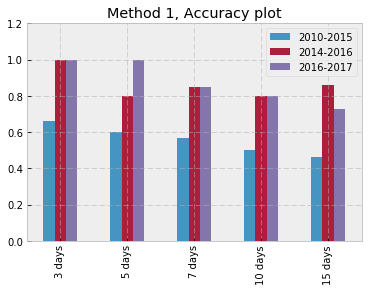

In [30]:
# Visualizing accuracy table

from collections import defaultdict

d = defaultdict()
d["2010-2015"] = [0.66, 0.6, 0.57, 0.5, 0.46]
d["2014-2016"] = [1.0, 0.8, 0.85, 0.8, 0.86]
d['2016-2017'] = [1.0, 1.0, 0.85, 0.8, 0.73]

acc_table = pd.DataFrame(d, index=['3 days', "5 days", '7 days', "10 days", "15 days"])
acc_table.plot(kind='bar', ylim=(0, 1.2), alpha=0.9, title="Method 1, Accuracy plot")
plt.show()

### Conclusion for this part

Although Linear Regression (LR) model shows good results based on R2_score and RMSE metrics, those results are not sutable to detect the trend of the market correcly. On the other hand, the outcome from LR model can be used as inputs for a binary problem in order to detect the movement of the price for the next day. Results show that classification gives much better results when training period is 1 and 2 years.Further improvements may include a wider range of features, for example, volume of shares and some technical indicators as well as testing several other regression models.